In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import seaborn as sns
import librosa
%matplotlib inline

In [2]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import Session

config = ConfigProto()
config.gpu_options.allow_growth = True
sess = Session(config=config)

if tf.test.gpu_device_name():
    print("GPU found")
else:
    print("No GPU found")

GPU found


## Look at the Test Set

In [3]:
dict_genres = {'Electronic':0, 'Experimental':1, 'Folk':2, 'Hip-Hop':3, 'Instrumental':4,'International':5, 'Pop' :6, 'Rock': 7}

In [4]:
model_root = load_model('models/model_finals/model_root.h5')
model_root_f1 = load_model('models/model_finals/model_root_f1.h5')
model_root_f1_1 = load_model('models/model_finals/model_root_f1_1.h5')
model_root_f1_2 = load_model('models/model_finals/model_root_f1_2.h5')
model_root_f2 = load_model('models/model_finals/model_root_f2.h5')
model_root_f2_1 = load_model('models/model_finals/model_root_f2_1.h5')
model_root_f2_2 = load_model('models/model_finals/model_root_f2_2.h5')

In [5]:
npzfile = np.load('data/test_arr.npz')
print(npzfile.files)

X_test = npzfile['arr_0']
y_test = npzfile['arr_1']
print(X_test.shape, y_test.shape)

['arr_0', 'arr_1']
(800, 640, 128) (800,)


In [6]:
y_test -= 1
print(np.amin(y_test), np.amax(y_test), np.mean(y_test))

0 7 3.5


In [7]:
y_true = y_test
#y_true = y_true[np.in1d(y_true, [1,5])]
#y_true_binary = np.invert(np.in1d(y_true, [1,5]))*1

In [8]:
X_test_raw = librosa.core.db_to_power(X_test, ref=1.0)
X_test = np.log(X_test_raw)

print(np.amin(X_test_raw), np.amax(X_test_raw), np.mean(X_test_raw))

1e-08 1.0000008783668917 0.0046238130656683


In [9]:
X_test = np.expand_dims(X_test, axis = -1)

In [10]:
print(X_test.shape, y_test.shape, y_true.shape)

(800, 640, 128, 1) (800,) (800,)


In [11]:
class ModelNodeTree():
    def __init__(self, model, left, right):
        self._model = model
        self._left = left
        self._right = right
        
    def predict(self, batch):
        y = self._model.predict(batch)
        y = np.argmax(y, axis=1)
        
        if np.sum(y == 0) > 0:
            if type(self._left) == int:
                y[y == 0] = self._left
            else:
                y[y == 0] = self._left.predict(batch[y == 0])
        
        if np.sum(y == 1) > 0:
            if type(self._right) == int:
                y[y == 1] = self._right
            else:
                y[y == 1] = self._right.predict(batch[y == 1])
        
        return y

In [12]:
f1_1 = ModelNodeTree(model_root_f1_1, 6, 7)
f1_2 = ModelNodeTree(model_root_f1_2, 2, 4)
f1 = ModelNodeTree(model_root_f1, f1_1, f1_2)

f2_1 = ModelNodeTree(model_root_f2_1, 3, 0)
f2_2 = ModelNodeTree(model_root_f2_2, 1, 5)
f2 = ModelNodeTree(model_root_f2, f2_1, f2_2)

root = ModelNodeTree(model_root, f1, f2)

In [13]:
y_pred = root.predict(X_test)

In [14]:
#X_test = X_test[np.in1d(y_test, [1,5])]
#y_pred = np.argmax(model_root.predict(X_test), axis=1)

In [17]:
labels = ["0","1"]
target_names = dict_genres.keys()

print(y_true.shape, y_pred.shape)
print(classification_report(y_true, y_pred, target_names=target_names))

(800,) (800,)
               precision    recall  f1-score   support

   Electronic       0.45      0.42      0.43       100
 Experimental       0.00      0.00      0.00       100
         Folk       0.22      0.21      0.22       100
      Hip-Hop       0.65      0.76      0.70       100
 Instrumental       0.40      0.30      0.34       100
International       0.19      0.35      0.24       100
          Pop       0.22      0.35      0.27       100
         Rock       0.58      0.44      0.50       100

     accuracy                           0.35       800
    macro avg       0.34      0.35      0.34       800
 weighted avg       0.34      0.35      0.34       800



C:\Users\Gabriele\anaconda3\envs\music-genre-recognition\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Gabriele\anaconda3\envs\music-genre-recognition\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Gabriele\anaconda3\envs\music-genre-recognition\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

Text(91.68, 0.5, 'predicted label')

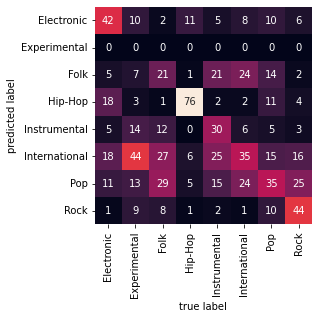

In [18]:
labels = [0,1]
mat = confusion_matrix(y_true, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, xticklabels=target_names, yticklabels=target_names)
plt.xlabel('true label')
plt.ylabel('predicted label')

In [19]:
print(accuracy_score(y_true, y_pred))

0.35375


#### TEST

In [42]:
i=0

print(list(dict_genres.keys())[list(dict_genres.values()).index(y_true[i])])

y_pred_single = root.predict(np.array([X_test[i]]))
print(list(dict_genres.keys())[list(dict_genres.values()).index(y_pred_single[0])])

Rock
Pop


In [ ]:
#dict_genres = {'Electronic':0, 'Experimental':1, 'Folk':2, 'Hip-Hop':3, 'Instrumental':4,'International':5, 'Pop' :6, 'Rock': 7}
i = 10
y_test[i]

In [ ]:
model_root.predict(np.array([X_test[i]]))